In [11]:
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import pprint
pp = pprint.PrettyPrinter(indent=4)

file_data = "Data/ca-dealers-used.csv"
df_data = pd.read_csv(file_data)

lst_removemake = ['smart']
df_data.dropna(inplace=True)
df_data = df_data[(~df_data['price'].isnull()) & (df_data['price']>1)]
df_data = df_data[~df_data['make'].isin(lst_removemake)]

df_data.loc[((df_data['fuel_type'].str.contains('Electric /')) | df_data['fuel_type'].str.contains('/ Electric')),'fuel_type'] = 'Hybrid'
df_data.loc[df_data['fuel_type'].str.contains('Compressed Natural Gas'),'fuel_type'] = 'Hybrid'
df_data.loc[((df_data['fuel_type'].str.contains('/')) & ~(df_data['fuel_type'].str.contains('Electric'))),'fuel_type'] = 'Gas'
df_data.loc[df_data['fuel_type'].isin(['Biodiesel','Diesel']),'fuel_type'] = 'Diesel'
df_data.loc[df_data['fuel_type'].isin(['E85','Unleaded','Premium Unleaded','Premium Unleaded; Unleaded']),'fuel_type'] = 'Gas'

df_data.drop(columns=['id','vin','stock_no','trim','engine_block','seller_name','street','city','zip'],inplace=True)
dict_colmap = {}
lst_objcolumns = list(df_data.select_dtypes(include=['object']).columns)
df_cleaned = df_data.copy()

# print(lst_objcolumns)
df_cleaned[lst_objcolumns] = df_cleaned[lst_objcolumns].astype('category')
for col in lst_objcolumns:
    df_cleaned[col+"_cat"] = df_cleaned[col].cat.codes
    dict_colmap[col] = pd.Series(df_cleaned[col+"_cat"].values.tolist(), index=df_cleaned[col].values.tolist()).to_dict()
df_cleaned.drop(columns=lst_objcolumns, inplace=True)
        
    
df_price = df_cleaned.pop("price")

with open('dict_colmap.txt', 'w') as outfile:
    json.dump(dict_colmap, outfile)
# print(df_data.head())
# print(dict_colmap)

C:\Users\dwittake\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (13,15) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [12]:
# df_data.columns
# df_data[['engine_size','engine_block']]
# df_data.drop_duplicates(subset=['vehicle_type','engine_size'])[['vehicle_type','engine_size']]

<AxesSubplot:>

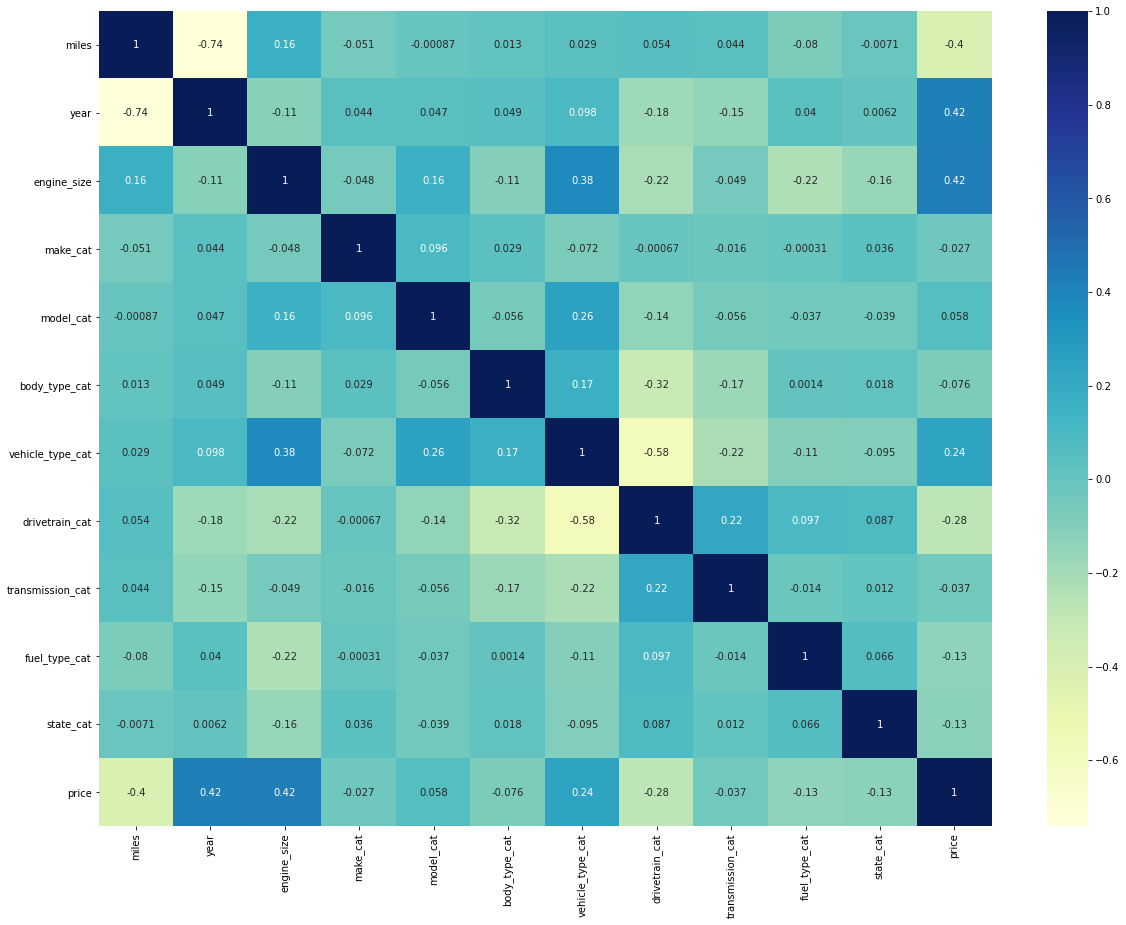

In [13]:
df_corr = df_cleaned.copy()
df_corr['price'] = df_price
correlations = df_corr.corr()

indx=correlations.index
plt.figure(figsize=(20,15))
sns.heatmap(df_corr[indx].corr(),annot=True,cmap="YlGnBu")

In [14]:
from sklearn import linear_model
from sklearn.metrics import r2_score
import sklearn.preprocessing as preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error
import joblib
from sklearn.model_selection import train_test_split

df_train = df_cleaned.copy()
lst_fldstodrop = [] # percentages below are with this cut out.
df_train.drop(columns=lst_fldstodrop,inplace=True)

x, y = df_train, df_price
x = preprocessing.StandardScaler().fit(x).transform(x.astype(float))
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.95, test_size = 0.05, random_state=1)
# https://docs.microsoft.com/en-us/azure/machine-learning/how-to-tune-hyperparameters
# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
    
# # 65-69% WITH POLFEAT 3
# #Using polynomial
# second_order = PolynomialFeatures(3)
# train_order_2 = second_order.fit_transform(x_train)
# lr_2 = linear_model.LinearRegression()
# lr_2.fit(train_order_2, y_train)
# test_order_2 = second_order.fit_transform(x_test)
# y_hat_2 = lr_2.predict(test_order_2)
# print(r2_score(y_true=y_test,y_pred=y_hat_2))

# BEST AT 95% WITH NO SET MAX DEPTH
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
rfregr  = RandomForestRegressor(max_depth=None, random_state=0)
rfregr.fit(x_train, y_train)
y_hat_rf = rfregr.predict(x_test)
print(r2_score(y_true=y_test,y_pred=y_hat_rf))

accuracy = rfregr.score(x_test, y_test)
print(accuracy)

print('Parameters currently in use:\n')


# 89% but takes forever. won't set higher than max depth 6
# gbreg = GradientBoostingRegressor(random_state=0, max_depth=6)
# gbreg.fit(x_train, y_train)
# y_hat_gb = gbreg.predict(x_test)
# print(r2_score(y_true=y_test,y_pred=y_hat_gb))

#NEVER GOT THIS TO FINISH
# svmregr = SVR(C=1.0, epsilon=0.1, cache_size=2000)
# svmregr.fit(x_train, y_train)
# y_hat_sv = svmregr.predict(x_test)
# print(r2_score(y_true=y_test,y_pred=y_hat_sv))

0.9606771935554197
0.9606771935554197
Parameters currently in use:



NameError: name 'pprint' is not defined

In [ ]:


fig = plt.figure()
fig.suptitle('y_test vs predictions')
plt.xlabel('y_test')
plt.ylabel('predictions')
plt.scatter(y_test,y_hat_2)

In [20]:

pp.pprint(rfregr.get_params())

{   'bootstrap': True,
    'ccp_alpha': 0.0,
    'criterion': 'mse',
    'max_depth': None,
    'max_features': 'auto',
    'max_leaf_nodes': None,
    'max_samples': None,
    'min_impurity_decrease': 0.0,
    'min_impurity_split': None,
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0,
    'n_estimators': 100,
    'n_jobs': None,
    'oob_score': False,
    'random_state': 0,
    'verbose': 0,
    'warm_start': False}
